# Richer analysis of precocity results

Second analysis of the 300k model, including information about individual venues of review.


In [37]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, pearsonr, spearmanr, zscore
from statistics import mean, stdev
from math import sqrt
import seaborn as sns
import random
from matplotlib import pyplot as plt

The results I'll use here were created by comparing books forward and backward using KL divergence, which is what Barron et al. do and what we preregistered. But the directory also includes results measured with cosine distance.

In any case we load them in the next cell. 

### Load the novelty / precocity results

The name "centersurprise" is because KLD/surprise is asymmetric and this is organized the same way Barron et al do it, where the books in the past (or future) are the reference point and the book in the center of the timeline is being compared to them.

In [4]:
results = []

for floor in range(0, 12000, 2000):
    df = pd.read_csv('../asym300/results/centersurprise_' + str(floor) + 'summary.tsv', sep = '\t', low_memory = False)
    results.append(df)

In [5]:
results = pd.concat(results)

In [6]:
results.shape

(10281, 7)

In [7]:
results.head()

,docid,novelty_1.0_25,novelty_0.05_25,transience_1.0_25,transience_0.05_25,resonance_1.0_25,resonance_0.05_25
0,njp.32101068163433,2.347248,1.282503,2.136945,1.270183,0.210303,0.012320
1,wu.89099446122,1.903351,1.078384,1.726808,0.989093,0.176543,0.089291
2,uc1.$b299322,2.004030,1.151198,1.954290,1.149878,0.049740,0.001319
3,mdp.39015032038120,1.643349,0.943281,1.686718,0.984908,-0.043369,-0.041626
4,mdp.39015005023844,1.926617,1.161039,1.955640,1.140674,-0.029022,0.020366


In [8]:
results.isna().sum()

docid                   0
novelty_1.0_25        499
novelty_0.05_25       499
transience_1.0_25     658
transience_0.05_25    658
resonance_1.0_25      988
resonance_0.05_25     988
dtype: int64

In [9]:
results = results.dropna(how = 'any')
results.shape

(9293, 7)

The columns with 1.0 are measured with respect to all volumes in a year. The columns with .05 are measured with respect to the 5% of most similar books (excluding books with the same author — and we're quite careful to exclude them, using fuzzy matching so we exclude them even if spelling is slightly different.

All the columns are measured in a 25-year window, which means we consider *all* the volumes from 1 year back to 25 years back, etc.

The thing labeled here as "resonance" is what we're calling "precocity." I haven't changed the term in the python script yet.

This dataframe includes volumes in and out of the topic model. 

### Now load metadata

This file contains both regular metadata and some summary statistics about reception generated in the ```reception_data.ipynb``` notebook. For instance, we know for each book whether its author was in Liza's lists of prizewinning authors and whether the book itself was a bestseller. 

For books that were matched to *Book Review Digest,* we also know the total review wordcount and the average review sentiment, although I caution that this estimate is a bit unreliable because sentiment is missing in many cases. In the final version we might train a model to estimate it for those cases.

Finally, there's a column called ```review_comparison``` This is an important tricky detail. The volumes in metadata include many volumes that I was able to match to book reviews. Some of these were included in the topic model that we used as a reference set, some were not. But I also included ~1,000 volumes that were in the model but *not* matched to reviews. Some of these might have been missed in the matching process, but many of these are probably things that didn't get reviewed or at any rate didn't get summarized in *Book Review Digest.* They are thus *likely* to be more obscure than the reviewed volumes. 

We can directly compare the reviewed to unreviewed volumes, but we can also combine these sets to create a reference set that fairly represents the average book in the model.

In [23]:
meta = pd.read_csv('richer_reception.tsv', sep = '\t')

In [24]:
meta.columns

Index(['docid', 'author', 'title', 'latestcomp', 'in_topic_model',
       'hathi_author', 'hathi_title', 'topicmodel_firstpub', 'birthyear',
       'us_national', 'authof3ormore', 'in_BRD', 'brd_review_year', 'rownum',
       'is_bestseller', 'bestseller_year', 'is_prize_author', 'is_retroavant',
       'retrospective_firstpub', 'consensus_earliest_date', 'author_age',
       'standardized_name', 'review_comparison', 'review_wordcount',
       'review_sentiment', 'N Y Times', 'Sat R of Lit', 'Booklist',
       'Boston Transcript', 'Books', 'Times [London] Lit Sup', 'New Yorker',
       'Nation', 'New Repub', 'Springf'd Republican', 'Spec', 'Wis Lib Bui',
       'Library J', 'Outlook', 'San Francisco Chronicle', 'NY Times',
       'Weekly Book Review', 'Lit R', 'Cleveland Open Shelf', 'Time', 'Klrkus',
       'Kirkus', 'Bookm', 'Pratt', 'Sat R', 'Commonweal', 'Cath World',
       'Christian Science Monitor', 'Book Week', 'Manchester Guardian'],
      dtype='object')

### What fraction of our books were matched in BRD

To find this out we have to construct a larger master-metadata file.

In [25]:
master_meta = pd.read_csv('../Metadata_construction/constructed_metadata.csv')

In [26]:
reviewedintm = sum(master_meta.in_topic_model & master_meta.in_BRD)
reviewedintm

4082

In [28]:
unreviewedintm = sum(master_meta.in_topic_model & ~master_meta.in_BRD)
unreviewedintm

25269

In [29]:
meta.review_comparison.value_counts()

review_comparison
not_in_tm                  4773
reviewed_tm_sample         4082
unreviewed_tm_sample       1019
here_for_another_reason     465
Name: count, dtype: int64

So, to create a set that represents the average book in our topic model, we need to supplement our 1019 unreviewed books with (4082/25269) * 1019 books.

In [33]:
k = int((4082/25269) * 1019)
print(k)
unreviewed_indices = set(meta[meta.review_comparison == 'unreviewed_tm_sample'].index.values.tolist())
reviewed_indices = set(meta[meta.review_comparison == 'reviewed_tm_sample'].index.values.tolist())
reviewed_sample = random.sample(list(reviewed_indices), k)
average_indices = unreviewed_indices.union(reviewed_sample)
print(len(average_indices))

164
1183


In [34]:
is_average = []
for idx, row in meta.iterrows():
    if idx in average_indices:
        is_average.append(True)
    else:
        is_average.append(False)

meta['is_average'] = is_average

#### merge the data and metadata

They both have a ```docid``` column.

In [35]:
print('meta', meta.shape)
print('results', results.shape)
data = meta.merge(results, on = 'docid')
data.shape

meta (10339, 56)
results (9293, 7)


(9293, 62)

### Does resonance show trends over the timeline?

Is there variation? If so we need to normalize.

In [36]:
b = sns.lineplot(data = data, x = 'consensus_earliest_date', y = 'resonance_0.05_25')
b.set(xlim = (1916, 1950), ylim = (-0.05, 0.10))

NameError: name 'sns' is not defined

[(1916.0, 1950.0), (-0.05, 0.2)]

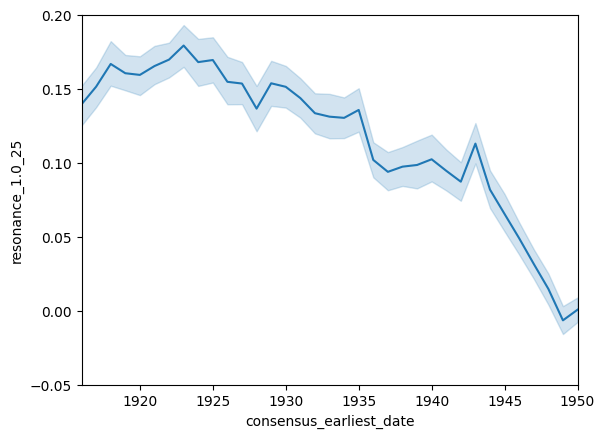

In [38]:
b = sns.lineplot(data = data, x = 'consensus_earliest_date', y = 'resonance_1.0_25')
b.set(xlim = (1916, 1950), ylim = (-0.05, 0.20))

Yes, there is definitely variation in these measures over time, especially if we use all the books. Why that is might be worth inquiring about. It looks a bit like something happened in the late 60s or 70s that made all late 1940s books different from their future -- at least in university libraries. Expanding range of author nationality?

But for the moment we can normalize the measures to z scores by year.

In [39]:
newdfs = []

for year, df in data.groupby('consensus_earliest_date'):
    df = df.loc[ : , ['resonance_0.05_25', 'resonance_1.0_25', 
                      'novelty_0.05_25', 'novelty_1.0_25',
                      'transience_0.05_25', 'transience_1.0_25']]
    df = df.apply(zscore)
    newdfs.append(df)

newvalues = pd.concat(newdfs)
newvalues.shape

(9293, 6)

In [40]:
newvalues.head()

,resonance_0.05_25,resonance_1.0_25,novelty_0.05_25,novelty_1.0_25,transience_0.05_25,transience_1.0_25
11,0.056625,0.063409,-1.096178,-0.979547,-0.986289,-0.900619
12,0.791459,0.429693,1.291830,2.093023,0.773486,1.740010
13,0.397099,0.236740,0.617966,0.246130,0.361629,0.143874
14,-0.945323,-0.749332,-0.815992,-0.501827,-0.286773,-0.206358
15,0.500557,0.213964,-1.072164,-1.171390,-1.166387,-1.122065


In [41]:
for column in ['resonance_0.05_25', 'resonance_1.0_25', 'novelty_0.05_25', 
               'novelty_1.0_25', 'transience_0.05_25', 'transience_1.0_25']:
    data[column] = newvalues[column]  # and we trust the index will reorder values        

In [42]:
data.head(7)

,docid,author,title,latestcomp,in_topic_model,hathi_author,hathi_title,topicmodel_firstpub,birthyear,us_national,...,Christian Science Monitor,Book Week,Manchester Guardian,is_average,novelty_1.0_25,novelty_0.05_25,transience_1.0_25,transience_0.05_25,resonance_1.0_25,resonance_0.05_25
0,mdp.39015059414725,"McKenna, Stephen","Lady Lilith, | a novel: Beong the first part o...",1967.0,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,False,-0.837610,-1.231565,-0.969434,-1.329334,0.784415,0.590292
1,wu.89099437782,"France, Anatole",The authorized English translations of the nov...,1924.0,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,False,1.630684,0.647925,1.945296,1.122691,-1.957325,-1.617604
2,nyp.33433076075344,"Lynd, Sylvia",The chorus : | a tale of love and folly / | $c...,1952.0,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,False,-1.338172,-1.724790,-1.387977,-1.760478,0.262475,0.318576
3,uc1.$b797656,"Rinehart, Mary Roberts","The romantics, | $c: by Mary Roberts Rinehart.",1958.0,True,"Rinehart, Mary Roberts",The romantics,1929.0,1876.0,True,...,0.0,0.0,0.0,True,-0.368822,-0.039531,-0.691400,-0.372929,1.134355,0.652539
4,pst.000006681135,"Housman, Laurence",Uncle Tomm Pudd.,1959.0,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,False,-0.644001,-0.633428,-0.466177,-0.367574,-0.464920,-0.492350
5,pst.000061539273,"Kipling, Rudyard",Tales of Rudyard Kipling.,1936.0,True,"Kipling, Rudyard",Tales of Rudyard Kipling,1928.0,1865.0,False,...,0.0,0.0,0.0,True,-0.118318,0.455830,0.076343,0.617630,-0.625114,-0.448283
6,uc1.$b322904,"Aiken, Conrad",Costumes | $c: by Eros,1973.0,True,"Aiken, Conrad",Costumes,1973.0,1889.0,False,...,0.0,0.0,0.0,False,-0.297872,-0.110027,-0.684045,-0.633240,1.345579,1.208647


In [43]:
pearsonr(data['novelty_0.05_25'], data['resonance_0.05_25'])

PearsonRResult(statistic=0.17376221772275618, pvalue=6.644167781616413e-64)

In [94]:
pearsonr(data['novelty_0.05_25'], data['transience_0.05_25'])

(0.915821860241009, 0.0)

In [44]:
pearsonr(data['transience_0.05_25'], data['resonance_0.05_25'])

PearsonRResult(statistic=-0.22614848480805802, pvalue=4.451504658672003e-108)

### Prizewinners and bestsellers: precocity

We comapre all prizewinners to all "average" books that are not prizewinners.

In [45]:
prizewinners = data.loc[data.is_prize_author == True, 'resonance_0.05_25']
not_prize = data.loc[(data.is_prize_author == False) & (data.is_average == True), 'resonance_0.05_25']

In [46]:
print(len(prizewinners), len(not_prize))
ttest_ind(prizewinners, not_prize)

475 874


TtestResult(statistic=2.6518384925456613, pvalue=0.00809944677732848, df=1347.0)

Definitely significant. A more interpretable measure of effect size is Cohen's *d*.

In [47]:
def cohens_d(a, b):
    cohens_d = (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))
    return cohens_d

In [48]:
cohens_d(prizewinners, not_prize)

0.15393326313196934

**Now let's do bestsellers.**

In [49]:
bestsellers = data.loc[data.is_bestseller == True, 'resonance_0.05_25']
not_best = data.loc[(data.is_bestseller == False) & (data.is_average == True), 'resonance_0.05_25']

In [50]:
print(len(bestsellers))
cohens_d(bestsellers, not_best)

282


0.25863336366806133

Higher than the prizewinners.

But the difference between bestsellers and prizewinners isn't statistically significant.

In [51]:
ttest_ind(bestsellers, prizewinners)

TtestResult(statistic=1.4024607996833431, pvalue=0.1611887265123303, df=755.0)

**Let's check the effect size if we use 100% of the books.**

In [52]:
prizewinners_100 = data.loc[data.is_prize_author == True, 'resonance_1.0_25']
not_prize_100 = data.loc[(data.is_prize_author == False) & (data.is_average == True), 'resonance_1.0_25']
cohens_d(prizewinners_100, not_prize_100)

0.04254594632615005

Much lower for prizewinners.

In [53]:
best_100 = data.loc[data.is_bestseller == True, 'resonance_1.0_25']
not_best_100 = data.loc[(data.is_bestseller == False) & (data.is_average == True), 'resonance_1.0_25']
cohens_d(best_100, not_best_100)

0.24798772178522002

Bestseller effect size persists if we use all the books.

### Being reviewed at all

In [54]:
inBRD = data.loc[data.in_BRD == True, 'resonance_0.05_25']
notinBRD = data.loc[(data.in_BRD == False) & (data.is_average == True), 'resonance_0.05_25']
print(len(inBRD))
cohens_d(inBRD, notinBRD)

8222


0.2676828021226414

### Prizewinner and bestsellers: novelty

Does novelty follow the same pattern?

In [55]:
prize_nov = data.loc[data.is_prize_author == True, 'novelty_0.05_25']
not_prize_nov = data.loc[data.is_prize_author == False & (data.is_average == True), 'novelty_0.05_25']
cohens_d(prize_nov, not_prize_nov)

-0.22342143681238338

In [56]:
ttest_ind(prize_nov, not_prize_nov)

TtestResult(statistic=-4.6445443867986285, pvalue=3.455092035363691e-06, df=9291.0)

Prizewinners are less novel than the average book!

#### What about bestsellers?

In [57]:
best_nov = data.loc[data.is_bestseller == True, 'novelty_0.05_25']
not_best_nov = data.loc[data.is_bestseller == False & (data.is_average == True), 'novelty_0.05_25']
cohens_d(best_nov, not_best_nov)

-0.37635997239275415

In [58]:
ttest_ind(best_nov, not_best_nov)

TtestResult(statistic=-5.761186281702963, pvalue=8.618340965277197e-09, df=9291.0)

Bestsellers are extremely not-novel. This means that in order to exceed other books at precocity they must ...

In [59]:
best_tra = data.loc[data.is_bestseller == True, 'transience_0.05_25']
obscure_tra = data.loc[data.is_bestseller == False & (data.is_average == True), 'transience_0.05_25']
cohens_d(best_tra, obscure_tra)

-0.4130160740230131

... have even *lower* transience. Precocity is novelty minus transience.

This sort of makes sense. We might expect bestsellers to be fairly conservative, sticking close to patterns that have succeeded in the past and will succeed in the future.

### What about the retrospective avant-garde?

In [60]:
retro = data.loc[data.is_retroavant == True, 'resonance_0.05_25']
not_retro = data.loc[(data.is_retroavant == False) & (data.is_average == True), 'resonance_0.05_25']
print(len(retro), len(not_retro))
print(cohens_d(retro, not_retro))
ttest_ind(retro, not_retro)

48 896
0.42464897344901126


TtestResult(statistic=2.6450012657720983, pvalue=0.008305051612528728, df=942.0)

A moderately strong effect size.

In [61]:
retro_nov = data.loc[data.is_retroavant == True, 'novelty_0.05_25']
not_retro_nov = data.loc[(data.is_retroavant == False) & (data.is_average == True), 'novelty_0.05_25']
cohens_d(retro_nov, not_retro_nov)

-0.2682015610834447

### Are in- and out-of-model volumes comparable?

We'll use reviewed volumes in and out of the model. They should be more similar to each other than reviewed and unreviewed volumes.

In [62]:
inmodel = data.loc[(data.in_BRD == True) & (data.in_topic_model == True), 'resonance_0.05_25']
inferred = data.loc[(data.in_BRD == True) & (data.in_topic_model == False), 'resonance_0.05_25']
print(len(inmodel), len(inferred))

4070 4152


In [63]:
ttest_ind(inmodel, inferred)

TtestResult(statistic=-0.1261398740648503, pvalue=0.8996242895916349, df=8220.0)

Yes, they are comparable.

### Review wordcount and sentiment

Wordcount is easy to compare, sentiment a little trickier.

We start by taking the Spearman correlation of precocity with wordcount. We're doing this only across reviewed books.

In [64]:
reviewed_data = data.loc[data['review_wordcount']> 0, :]

spearmanr(reviewed_data['resonance_0.05_25'], reviewed_data['review_wordcount'])

SignificanceResult(statistic=0.0929929310568826, pvalue=2.933365717309773e-17)

Cohen's $d = \frac{2 * r}{\sqrt{1 - r^2}}$

In [65]:
def r2d(r):
    d = (2*r) / sqrt(1 - r**2)
    return d

In [66]:
r2d(.093)

0.18680961255590703

What happens if we consider unreviewed books as zero wordcount?

In [67]:
reviewed_data_with_zeroes = data.loc[(data['review_wordcount']> 0) | 
                                     (data.review_comparison == 'unreviewed_tm_sample'), :]

In [68]:
spearmanr(reviewed_data_with_zeroes['resonance_0.05_25'], reviewed_data_with_zeroes['review_wordcount'])

SignificanceResult(statistic=0.10924947561595938, pvalue=3.467989290206453e-25)

In [69]:
r2d(.10925)

0.21981575015211152

In [70]:

spearmanr(reviewed_data_with_zeroes['novelty_0.05_25'], reviewed_data_with_zeroes['review_wordcount'])

SignificanceResult(statistic=-0.15991052652480653, pvalue=2.2895983031696743e-52)

In [71]:
r2d(-0.1599)

-0.3239684311919988

What if we use all the data?

In [72]:
spearmanr(reviewed_data['resonance_1.0_25'], reviewed_data['review_wordcount'])

SignificanceResult(statistic=-0.027434698504648407, pvalue=0.012855840690158644)

**Association of novelty with wordcount.**

In [73]:
spearmanr(reviewed_data['novelty_0.05_25'], reviewed_data['review_wordcount'])

SignificanceResult(statistic=-0.14287774066514, pvalue=9.373463937390389e-39)

Very novel books are **less** likely to have a lot written about them. Reviewed books have a lot of precocity because they nevertheless tend to resemble the future. In other words, transience is still low enough to make precocity positive.

In [74]:
spearmanr(reviewed_data['transience_0.05_25'], reviewed_data['review_wordcount'])

SignificanceResult(statistic=-0.17958798740439658, pvalue=1.48562531652504e-60)

**Now sentiment.** Sentiment is a little trickier because it doesn't make sense to treat the sentiment of unreviewed books as zero. So we have to actually select a subset where sentiment is non-null -- i.e. the subset of reviewed books.

In [75]:
spearmanr(reviewed_data['resonance_0.05_25'], reviewed_data['review_sentiment'])

SignificanceResult(statistic=-0.04325245027292856, pvalue=8.739286419562799e-05)

A weak *negative* correlation with resonance. But there are many reasons to be suspicious of sentiment measures. Note for instance that sentiment correlates *inversely* with wordcount.

In [76]:
r2d(-0.04325)

-0.08658101550428185

In [77]:
spearmanr(reviewed_data['novelty_0.05_25'], reviewed_data['review_sentiment'])

SignificanceResult(statistic=0.13868529130413243, pvalue=1.3624448040381854e-36)

In [78]:
r2d(0.1387)

0.2801073938387348

In [79]:
spearmanr(reviewed_data['review_sentiment'], reviewed_data['review_wordcount'])

SignificanceResult(statistic=-0.14092669488030063, pvalue=9.693210054795761e-38)

I suspect magazines that write long reviews are also more likely to write harsh reviews than those that are just producing a short "notice" of a book. Also the editors of BRD might be more likely to include a very harsh review to balance out perspectives on a book if it already has multiple reviews.

### Individual magazines

Let's see which magazines predict success.

In [80]:
data.shape

(9293, 62)

In [81]:
reviewed_data.shape

(8222, 62)

In [82]:
reviewed_data_with_zeroes.shape

(8955, 62)

In [84]:
reviewed_data_with_zeroes.columns[25]

'N Y Times'

In [86]:
reviewed_data_with_zeroes.columns[54]

'Manchester Guardian'

In [87]:
rdwzcols = reviewed_data_with_zeroes.columns

In [117]:
venue_effects = []

for i in range(25, 55):
	print(i, rdwzcols[i])
	spear_result = spearmanr(reviewed_data_with_zeroes[rdwzcols[i]], reviewed_data_with_zeroes[['resonance_0.05_25']])
	print(spear_result)
	r2d_result = r2d(spear_result[0])
	print(r2d_result)
	if not pd.isnull(r2d_result):
		venue_effects.append(r2d_result)
	print()

25 N Y Times
SignificanceResult(statistic=0.03333317658075913, pvalue=0.0016061724266435375)
0.06670342056812584

26 Sat R of Lit
SignificanceResult(statistic=0.04970983782238334, pvalue=2.52206642443229e-06)
0.09954274015572102

27 Booklist
SignificanceResult(statistic=-0.0470623901373216, pvalue=8.373633960716908e-06)
-0.09422919075684194

28 Boston Transcript
SignificanceResult(statistic=0.03907881703455882, pvalue=0.00021648576791515417)
0.07821738188034925

29 Books
SignificanceResult(statistic=0.02259236001671609, pvalue=0.03252413781936332)
0.04519625592304947

30 Times [London] Lit Sup
SignificanceResult(statistic=-0.06417164546257706, pvalue=1.2166395532658078e-09)
-0.12860836874076872

31 New Yorker
SignificanceResult(statistic=0.031196935369749004, pvalue=0.003152127288230313)
0.06242425529927744

32 Nation
SignificanceResult(statistic=0.10689122337199258, pvalue=3.56482992663452e-24)
0.21501432382355778

33 New Repub
SignificanceResult(statistic=0.1353076724660047, pvalue=7

/var/folders/vr/dvcptvds6pzfv78p3nwbb01c0000gq/T/ipykernel_857/3317220393.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spear_result = spearmanr(reviewed_data_with_zeroes[rdwzcols[i]], reviewed_data_with_zeroes[['resonance_0.05_25']])
/var/folders/vr/dvcptvds6pzfv78p3nwbb01c0000gq/T/ipykernel_857/3317220393.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spear_result = spearmanr(reviewed_data_with_zeroes[rdwzcols[i]], reviewed_data_with_zeroes[['resonance_0.05_25']])


In [127]:
review_lengths = []
venue_titles = []
venue_size = []

for i in range(25, 55):
	non_zero_values = [value for value in reviewed_data_with_zeroes[rdwzcols[i]] if value != 0]
	if len(non_zero_values) > 0:
		mean_value = sum(non_zero_values) / len(non_zero_values)
		review_lengths.append(mean_value)
		title = rdwzcols[i]
		if title == "Cleveland Open Shelf":
			title = "Cleveland"
		elif title == "Klrkus":
			title = "Kirkus"
		venue_titles.append(title)
		
		if len(non_zero_values) > 1000:
			venue_size.append('> 1000 reviews')
		else:
			venue_size.append('< 1000 reviews')

print(len(review_lengths), len(venue_effects))

28 28


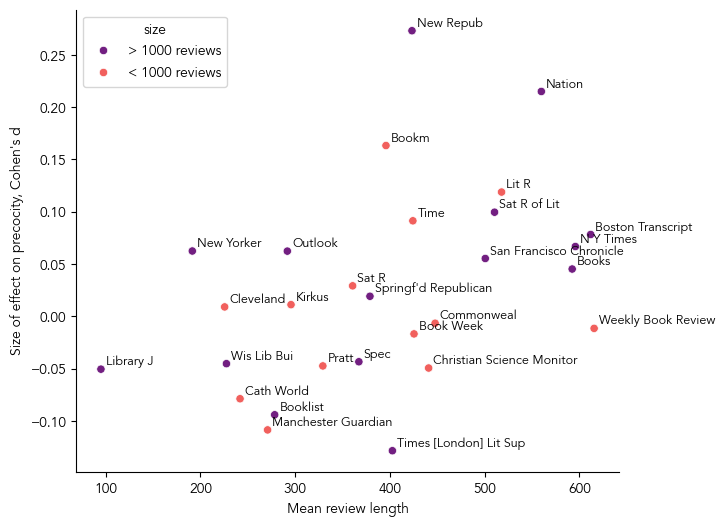

In [129]:

plt.figure(figsize=(7,6))
import matplotlib as mpl
mpl.rc('font',family='Avenir')

vis_df = pd.DataFrame({'venue': venue_titles, 'effect': venue_effects, 
						'length': review_lengths, 'size': venue_size})

hfont = {'fontname':'Avenir'}

# Create the scatterplot
sns.scatterplot(x='length', y='effect', data=vis_df, hue='size', palette='magma')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels to the points
for i in range(len(vis_df)):
	plt.text(vis_df['length'][i] + 5, vis_df['effect'][i] + 0.004, vis_df['venue'][i], 
			fontsize=9, **hfont)

# Set the axis labels
plt.xlabel('Mean review length', **hfont)
plt.ylabel("Size of effect on precocity, Cohen's d", **hfont)

plt.savefig('venue_effects.png', bbox_inches='tight', dpi = 300)

# Show the plot
plt.show()

## Visualizations

define a function that accepts two groups of coordinates and plots them

In [162]:
def selectpoints(x1, y1, k):
    assert len(x1) == len(y1)
    length1 = len(x1)
    if length1 < k:
        k1 = length1
    else:
        k1 = k
    indices = random.sample([x for x in range(length1)], k1)
    x1 = np.array(x1)[indices]
    y1 = np.array(y1)[indices]
    return x1, y1

def plotslopes(x1, x2, y1, y2, k, lab):
    x1, y1 = selectpoints(x1, y1, k)
    x2, y2 = selectpoints(x2, y2, k)
    df1 = pd.DataFrame({'x1': x1, 'y1': y1})
    df2 = pd.DataFrame({'x2': x2, 'y2': y2})
    
    fig, ax = plt.subplots(figsize = (8, 5))
    seaborn.regplot(x= x1, y= y1, data= df1, ax=ax, scatter_kws={'s': 3}, label = "contrast set")
    seaborn.regplot(x = x2, y = y2, data = df2, ax=ax, color='r', scatter_kws={'s': 3}, label = lab)
    plt.legend()
    plt.title(lab)
    
    plt.xlabel('Novelty')
    
    plt.ylabel('Transience')
    plt.show()

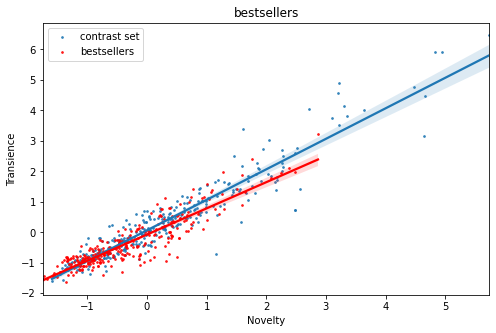

In [164]:
x1 = data.loc[data.is_average == True, 'novelty_0.05_25']
x2 = data.loc[data.is_bestseller == True, 'novelty_0.05_25']
y1 = data.loc[data.is_average == True, 'transience_0.05_25']
y2 = data.loc[data.is_bestseller == True, 'transience_0.05_25']
plotslopes(x1, x2, y1, y2, 300, 'bestsellers')

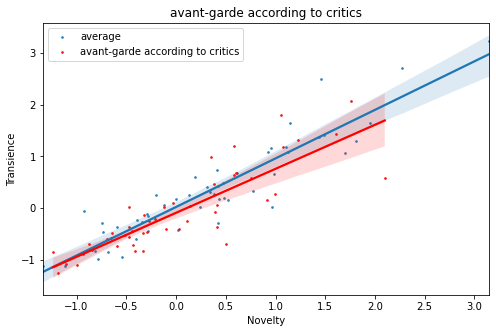

In [145]:
x1 = data.loc[data.is_average == True, 'novelty_0.05_25']
x2 = data.loc[data.is_retroavant == True, 'novelty_0.05_25']
y1 = data.loc[data.is_average == True, 'transience_0.05_25']
y2 = data.loc[data.is_retroavant == True, 'transience_0.05_25']
plotslopes(x1, x2, y1, y2, 50, "avant-garde according to critics")

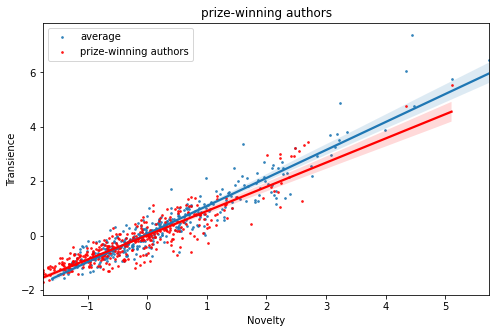

In [147]:
x1 = data.loc[data.is_average == True, 'novelty_0.05_25']
x2 = data.loc[data.is_prize_author == True, 'novelty_0.05_25']
y1 = data.loc[data.is_average == True, 'transience_0.05_25']
y2 = data.loc[data.is_prize_author == True, 'transience_0.05_25']
plotslopes(x1, x2, y1, y2, 350, "prize-winning authors")

In [150]:
def plotslopesNR(x1, x2, y1, y2, k, lab):
    x1, y1 = selectpoints(x1, y1, k)
    x2, y2 = selectpoints(x2, y2, k)
    df1 = pd.DataFrame({'x1': x1, 'y1': y1, 'label': ['avg'] * len(x1)})
    df2 = pd.DataFrame({'x2': x2, 'y2': y2, 'label': ['best'] * len(x2)})
    
    fig, ax = plt.subplots(figsize = (8, 5))
    seaborn.regplot(x= x1, y= y1, data= df1, ax=ax, scatter_kws={'s': 3}, label = "average")
    seaborn.regplot(x = x2, y = y2, data = df2, ax=ax, color='r', scatter_kws={'s': 3}, label = lab)
    plt.legend()
    plt.title(lab)
    
    plt.xlabel('Novelty')
    
    plt.ylabel('Resonance')
    plt.show()
    return pd.concat([df1, df2])

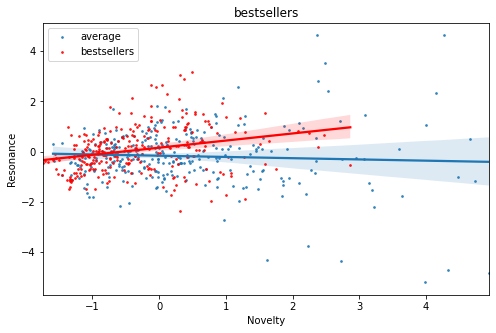

In [153]:
x1 = data.loc[data.is_average == True, 'novelty_0.05_25']
x2 = data.loc[data.is_bestseller == True, 'novelty_0.05_25']
y1 = data.loc[data.is_average == True, 'resonance_0.05_25']
y2 = data.loc[data.is_bestseller == True, 'resonance_0.05_25']
plotdf = plotslopesNR(x1, x2, y1, y2, 300, 'bestsellers')

In [154]:
plotdf.to_csv('bestresonance.tsv', sep = '\t')

In [158]:
bestavg = data.loc[(data.is_bestseller) | (data.is_average), : ]
bestavg.to_csv('bestresfull.tsv', sep = '\t')

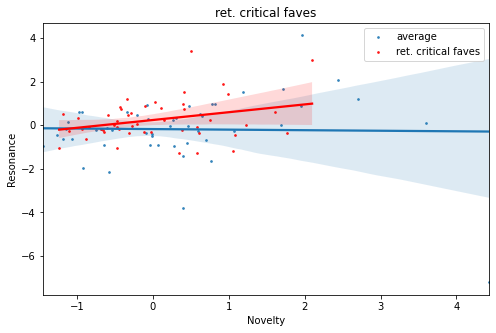

In [156]:
x1 = data.loc[data.is_average == True, 'novelty_0.05_25']
x2 = data.loc[data.is_retroavant == True, 'novelty_0.05_25']
y1 = data.loc[data.is_average == True, 'resonance_0.05_25']
y2 = data.loc[data.is_retroavant == True, 'resonance_0.05_25']
plotdf = plotslopesNR(x1, x2, y1, y2, 50, 'ret. critical faves')

In [119]:
np.mean(y2)

-0.3636305807320293

### Multivariate linear regression

In [109]:
import statsmodels.api as sm

In [115]:
X = sm.add_constant(data.loc[ : , ['review_wordcount', 'is_bestseller', 'prize_author']],
                    prepend = False)
X['is_bestseller'] = X['is_bestseller'].map({True: 1, False: 0})
X['prize_author'] = X['prize_author'].map({True: 1, False: 0})
y = data.loc[ : , 'resonance_0.05_25']

In [118]:
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      resonance_0.05_25   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     37.59
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           4.90e-24
Time:                        09:21:13   Log-Likelihood:                -7739.8
No. Observations:                5494   AIC:                         1.549e+04
Df Residuals:                    5490   BIC:                         1.551e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
review_wordcount  4.228e-05   4.23e-06  

If we include wordcount with the bestseller and prizewinner conditions, only wordcount is significant. Now, this may be partly because we have fuller data for wordcount.

**Let's try sentiment** across the rows where we have sentiment data.

In [120]:
X = sm.add_constant(data.loc[~pd.isnull(data.review_sentiment), ['review_wordcount', 'is_bestseller',
                                                                 'prize_author', 'review_sentiment']],
                    prepend = False)
X['is_bestseller'] = X['is_bestseller'].map({True: 1, False: 0})
X['prize_author'] = X['prize_author'].map({True: 1, False: 0})
y = data.loc[~pd.isnull(data.review_sentiment), 'resonance_0.05_25']
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      resonance_0.05_25   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     20.70
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           6.49e-17
Time:                        09:24:13   Log-Likelihood:                -5939.2
No. Observations:                4303   AIC:                         1.189e+04
Df Residuals:                    4298   BIC:                         1.192e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
review_wordcount  3.686e-05    4.9e-06  

If we include sentiment, it's an effective (negative) predictor across the rows where sentiment exists.

### Do we find an "inverse U"?

In other words, are books rewarded for achieving a medium level of "optimum differentiation" from the past?

Following the model of Silver, Childress, et al., we might expect review wordcount or review sentiment to peak at medium levels of novelty.

In [137]:
summarydf = data.loc[ : , ['review_wordcount', 'novelty_0.05_25', 'resonance_0.05_25']]
summarydf['relative_novelty'] = pd.qcut(summarydf['novelty_0.05_25'], 25, labels = False)
summarydf['relative_precocity'] = pd.qcut(summarydf['resonance_0.05_25'], 25, labels = False)
summarydf.head()

,review_wordcount,novelty_0.05_25,resonance_0.05_25,relative_novelty,relative_precocity
0,2400.0,-0.235232,0.907823,11,20
1,5010.0,-1.012464,0.154430,3,14
2,600.0,0.961344,-0.920786,21,3
3,930.0,-0.535305,-0.974632,7,3
4,3600.0,-1.927121,-0.444320,0,8


In [138]:
sns.set(rc = {'figure.figsize':(9,6)})

<AxesSubplot:xlabel='relative_novelty', ylabel='review_wordcount'>

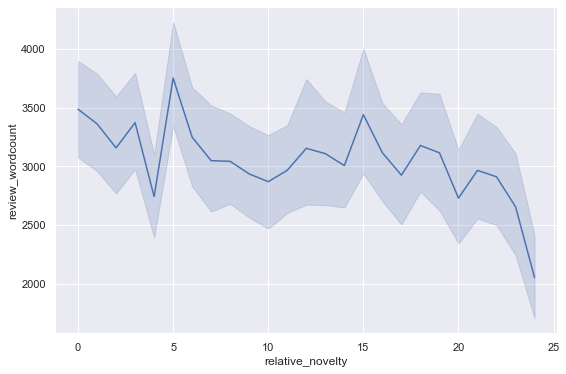

In [139]:
sns.lineplot(x = 'relative_novelty', y = 'review_wordcount', data = summarydf)

**That is not really an inverse U.** Less is written about a book as it gets more novel.

What if we try precocity?

<AxesSubplot:xlabel='relative_precocity', ylabel='review_wordcount'>

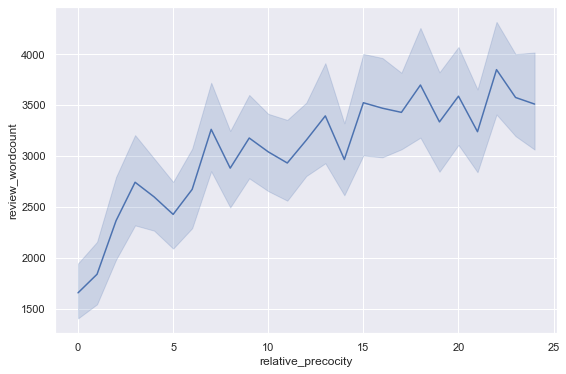

In [140]:
sns.lineplot(x = 'relative_precocity', y = 'review_wordcount', data = summarydf)

Still not an inverse U.

**What if we try with sentiment?**

In [143]:
summarydf = data.loc[~pd.isnull(data.review_sentiment), ['review_wordcount', 'review_sentiment',
                                                      'novelty_0.05_25', 'resonance_0.05_25']]
summarydf['relative_novelty'] = pd.qcut(summarydf['novelty_0.05_25'], 25, labels = False)
summarydf['relative_precocity'] = pd.qcut(summarydf['resonance_0.05_25'], 25, labels = False)
summarydf.head()

,review_wordcount,review_sentiment,novelty_0.05_25,resonance_0.05_25,relative_novelty,relative_precocity
0,2400.0,3.715599,-0.235232,0.907823,11,20
1,5010.0,3.500459,-1.012464,0.154430,3,14
2,600.0,3.759941,0.961344,-0.920786,21,3
3,930.0,3.706520,-0.535305,-0.974632,8,2
4,3600.0,3.613030,-1.927121,-0.444320,0,7


<AxesSubplot:xlabel='relative_novelty', ylabel='review_sentiment'>

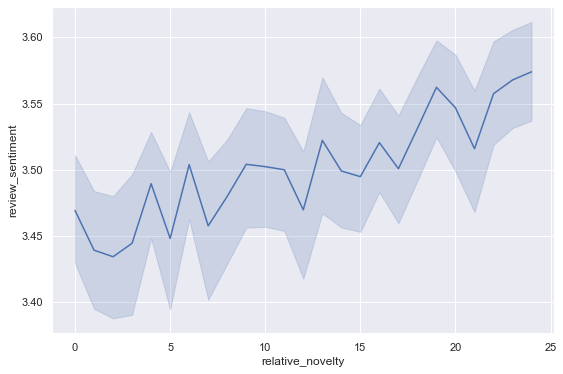

In [144]:
sns.lineplot(x = 'relative_novelty', y = 'review_sentiment', data = summarydf)

Still not an inverse U! Sentiment gets more positive as a book gets more novel.

### We could try to do the same thing for the cosine results

In [70]:
cosresults = pd.read_csv('results/centersurprise_0cossummary.tsv', sep = '\t', low_memory = False)

In [75]:
cosdata = meta.merge(cosresults, on = 'docid')
cosdata.shape

(5494, 24)